<a href="https://colab.research.google.com/github/BattulaUdayasri/Brain-Tumor-Using-DL/blob/main/BrainTumorUsingDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
import zipfile
z=zipfile.ZipFile('archive.zip')
z.extractall()



In [ ]:
folder='brain_tumor_dataset/yes/'
count=1
for filename in os.listdir(folder):
  source=folder+filename
  destination=folder+"Y_"+str(count)+".jpg"
  os.rename(source,destination)
  count+=1
print("All files are renamed in the yes dir.")


All files are renamed in the yes dir.


In [ ]:
folder="brain_tumor_dataset/no/"
count=1
for filename in os.listdir(folder):
  source=folder+filename
  destination=folder+"N_"+str(count)+".jpg"
  os.rename(source,destination)
  count+=1
print("All files are renamed in the no dir.")



All files are renamed in the no dir.


In [ ]:
listyes=os.listdir("brain_tumor_dataset/yes/")
number_files_yes=len(listyes)
print(number_files_yes)

listno=os.listdir("brain_tumor_dataset/no/")
number_files_no=len(listno)
print(number_files_no)


155
98


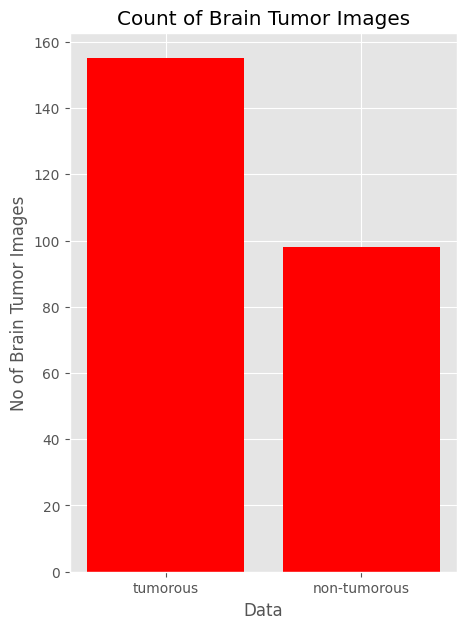

In [ ]:
data={'tumorous':number_files_yes,"non-tumorous":number_files_no}
typex=data.keys()
values=data.values()

fig=plt.figure(figsize=(5,7))

plt.bar(typex,values,color="red")
plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [ ]:
def timing(sec_elapsed):
  h=int(sec_elapsed/(60*60))
  m=int(sec_elapsed%(60*60)/60)
  s=sec_elapsed%60
  return f"{h}:{m}:{s}"



In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break


In [ ]:
import time
start_time=time.time()
yes_path='brain_tumor_dataset/yes/'
no_path='brain_tumor_dataset/no/'
augmented_data_path='augmented_data/'
os.makedirs(augmented_data_path+'yes',exist_ok=True)
os.makedirs(augmented_data_path+'no',exist_ok=True)
augmented_data(file_dir=yes_path,n_generated_samples=6,save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir=no_path,n_generated_samples=9,save_to_dir=augmented_data_path+'no')
end_time=time.time()
execution_time=end_time-start_time
print(f"Elapsed time: {timing(execution_time)}")

Elapsed time: 0:1:50.873388051986694


In [ ]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")



In [ ]:
data_summary(augmented_data_path)


Number of sample: 2065
1085 Number of positive sample in percentage: 52.54237288135593%
980 Number of negative sample in percentage: 47.45762711864407%


In [ ]:
listyes=os.listdir("augmented_data/yes/")
number_files_yes=len(listyes)
print(number_files_yes)
listno=os.listdir("augmented_data/no/")
number_files_no=len(listno)
print(number_files_no)

1085
980


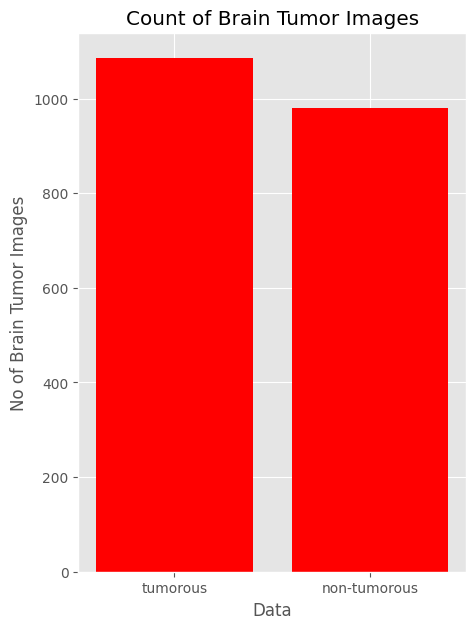

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:

import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

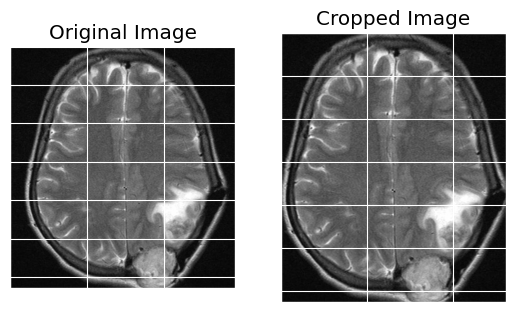

array([[[10, 10, 10],
        [ 9,  9,  9],
        [10, 10, 10],
        ...,
        [13, 13, 13],
        [13, 13, 13],
        [12, 12, 12]],

       [[ 9,  9,  9],
        [ 8,  8,  8],
        [ 8,  8,  8],
        ...,
        [12, 12, 12],
        [12, 12, 12],
        [12, 12, 12]],

       [[ 7,  7,  7],
        [ 6,  6,  6],
        [ 6,  6,  6],
        ...,
        [10, 10, 10],
        [11, 11, 11],
        [11, 11, 11]],

       ...,

       [[ 9,  9,  9],
        [ 8,  8,  8],
        [10, 10, 10],
        ...,
        [ 9,  9,  9],
        [ 8,  8,  8],
        [ 7,  7,  7]],

       [[ 9,  9,  9],
        [ 9,  9,  9],
        [11, 11, 11],
        ...,
        [10, 10, 10],
        [10, 10, 10],
        [ 9,  9,  9]],

       [[10, 10, 10],
        [ 9,  9,  9],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]]], dtype=uint8)
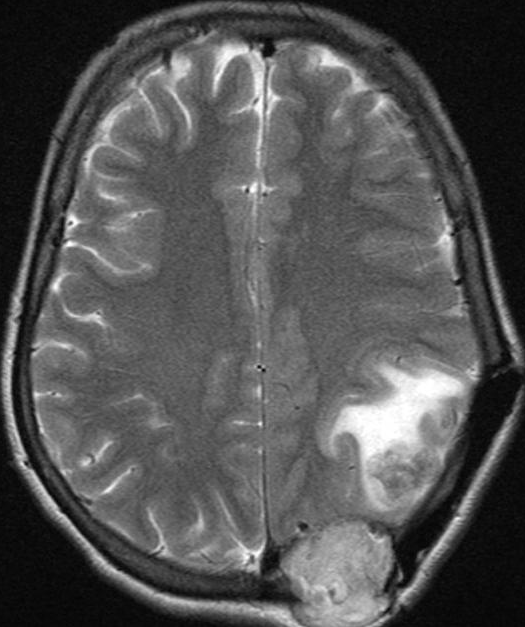

In [ ]:
img=cv2.imread("/content/yes/Y102.jpg")
crop_brain_tumor(img,plot=True)


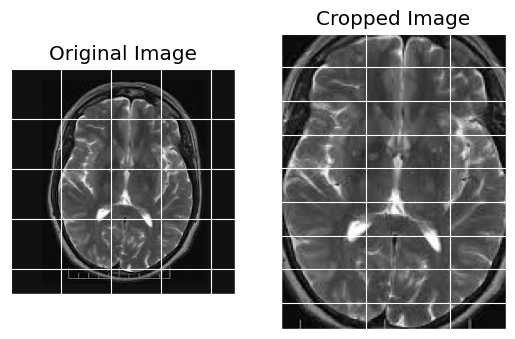

array([[[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       ...,

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [12, 12, 12],
        [11, 11, 11],
        [11, 11, 11]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [12, 12, 12],
        [11, 11, 11],
        [11, 11, 11]],

       [[11, 11, 11],
        [11, 11, 11],
        [11, 11, 11],
        ...,
        [12, 12, 12],
        [11, 11, 11],
        [11, 11, 11]]], dtype=uint8)
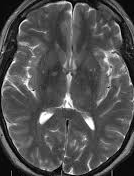

In [ ]:
img=cv2.imread("/content/no/no 3.jpg")
crop_brain_tumor(img,plot=True)


In [ ]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [ ]:

from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [ ]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))


Number of example is : 2065
X SHAPE is : (2065, 240, 240, 3)
y SHAPE is : (2065,)


In [ ]:

print(y)

[1 1 1 ... 0 1 0]


In [ ]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()



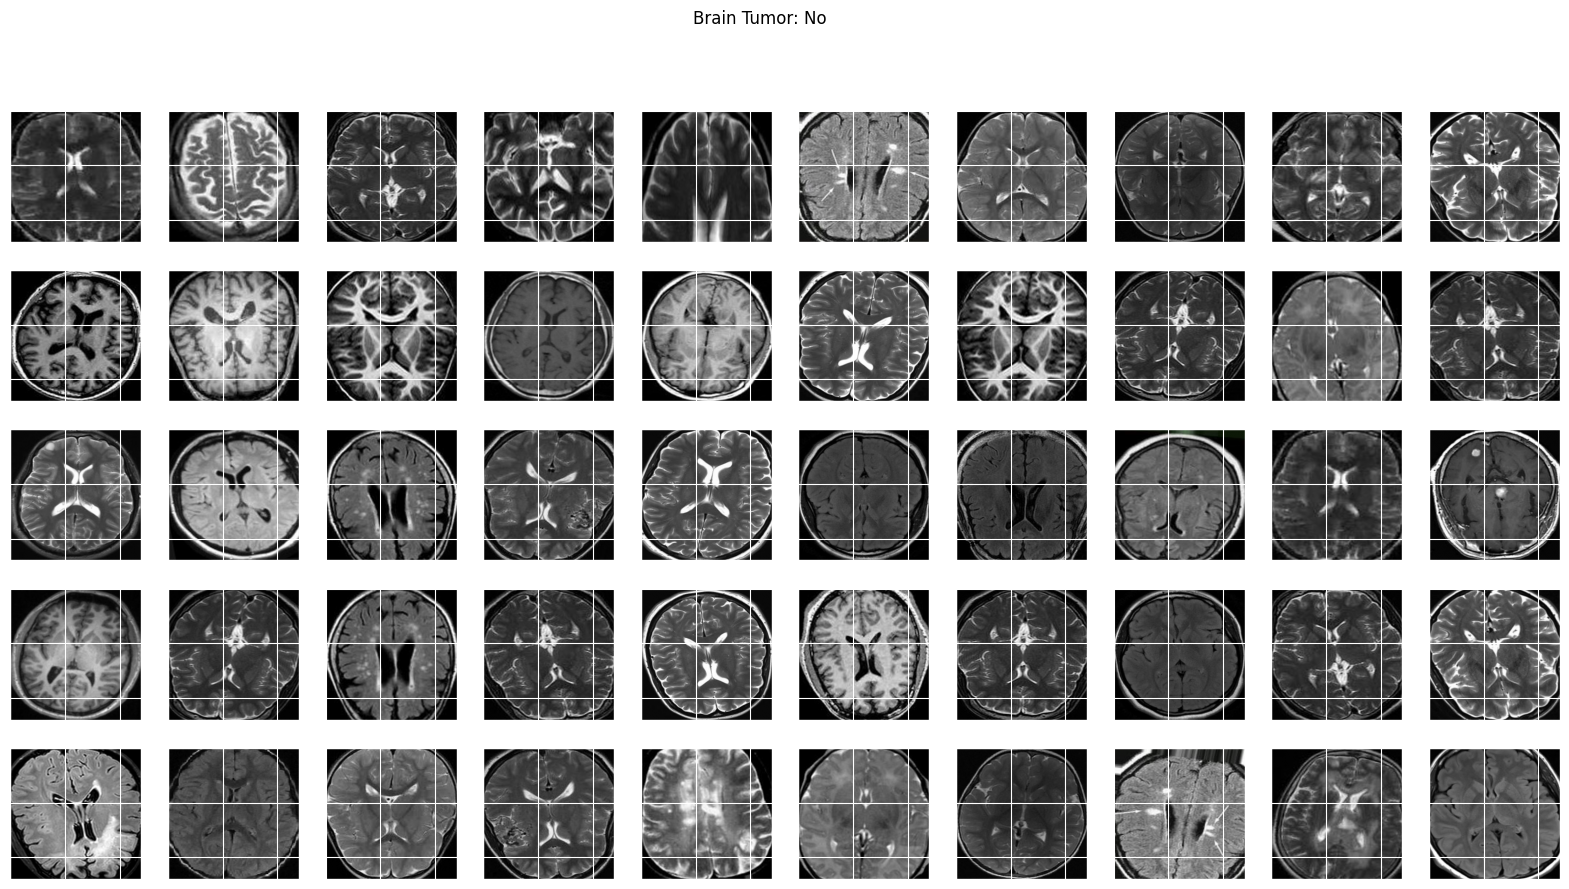

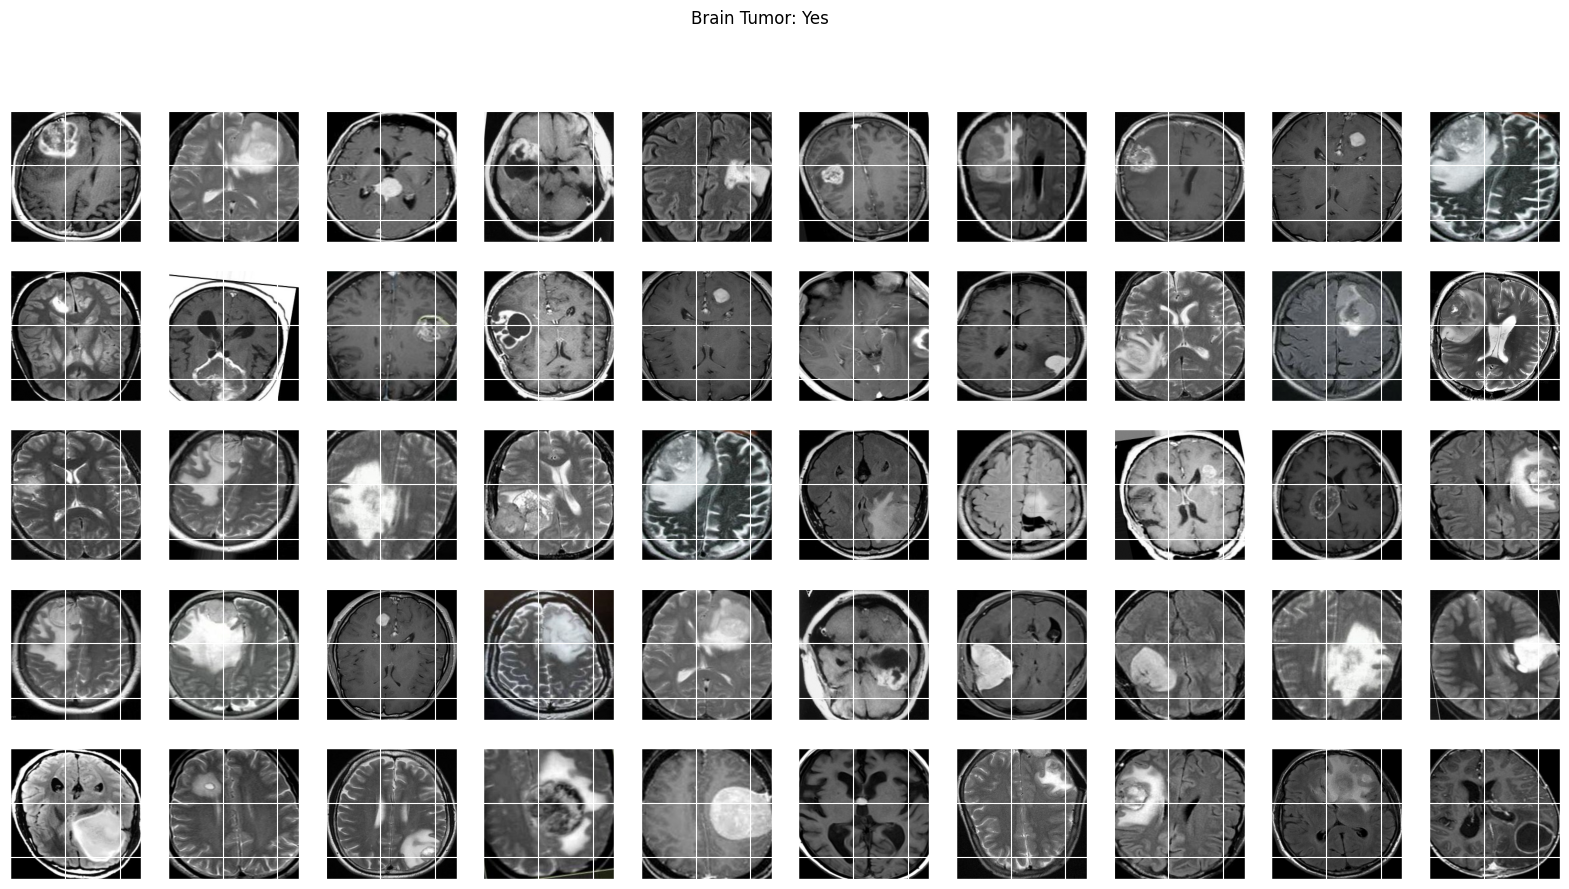

In [ ]:
plot_sample_images(X,y)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)


In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)


In [ ]:

if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [ ]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')
